In [1]:
import pandas as pd
from datetime import datetime, date, timedelta
import pymysql
import os
from dotenv import load_dotenv
import numpy as np

## 前置作業

In [2]:
def create_pymysql_connect():
    """
    自動透過pymysql建立連線，回傳conn連線物件。
    所需各項資料請寫入.env檔案中。請勿直接寫於程式中。
    """

    load_dotenv()

    username = os.getenv("MYSQL_USERNAME")
    password = os.getenv("MYSQL_PASSWORD")
    target_ip = os.getenv("MYSQL_IP")
    target_port = int(os.getenv("MYSQL_PORTT"))
    db_name = os.getenv("MYSQL_DB_NAME")

    conn = pymysql.connect(
        host=target_ip,
        port=target_port,
        user=username,
        password=password,
        database=db_name,
        charset='utf8mb4'
    )

    return conn


def E_load_from_sql(table_name: str) -> pd.DataFrame:
    """
    輸入欲查詢的表名table_name，透過pymysql連線資料庫，
    並取得該表後將其轉成dataframe。

    連線所需資訊請寫入.env中，請勿寫入程式中。
    """

    conn = create_pymysql_connect()
    sql = f"SELECT * FROM {table_name}"

    try:
        df = pd.read_sql(sql, conn)
        return df.to_dict(orient='records')

    except Exception as e:
        raise Exception(f"讀取{table_name}表時發生錯誤：{e}")

In [3]:
data_salon = E_load_from_sql(table_name="salon")
df_salon = pd.DataFrame(data=data_salon)

data_hotel = E_load_from_sql(table_name="hotel")
df_hotel = pd.DataFrame(data=data_hotel)

data_hospital = E_load_from_sql(table_name="hospital")
df_hospital = pd.DataFrame(data=data_hospital)

data_supplies = E_load_from_sql(table_name="supplies")
df_supplies = pd.DataFrame(data=data_supplies)

data_restaurant = E_load_from_sql(table_name="restaurant")
df_restaurant = pd.DataFrame(data=data_restaurant)

data_shelter = E_load_from_sql(table_name="shelter")
df_shelter = pd.DataFrame(data=data_shelter)

C:\Users\add41\AppData\Local\Temp\ipykernel_18196\1534151327.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, conn)
C:\Users\add41\AppData\Local\Temp\ipykernel_18196\1534151327.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, conn)
C:\Users\add41\AppData\Local\Temp\ipykernel_18196\1534151327.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, conn)
C:\Users\add41\AppData\Local\Temp\ipykernel_18196\1534151327.py:39: UserWarning: pandas only supports S

In [4]:
df_main = pd.concat([df_salon, df_hotel, df_hospital, df_supplies, df_restaurant, df_shelter], ignore_index=True)
df_main["city_id"] = df_main["loc_id"].str[:3]

In [5]:
data_loc = E_load_from_sql(table_name="location")
df_loc = pd.DataFrame(data=data_loc)

C:\Users\add41\AppData\Local\Temp\ipykernel_18196\1534151327.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, conn)


In [6]:
data_category = E_load_from_sql(table_name="category")
df_category = pd.DataFrame(data=data_category)

C:\Users\add41\AppData\Local\Temp\ipykernel_18196\1534151327.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, conn)


In [7]:
data_pet = E_load_from_sql(table_name="pet_regis")
df_pet = pd.DataFrame(data=data_pet)
df_pet["city_id"] = df_pet["loc_id"].str[:3]

C:\Users\add41\AppData\Local\Temp\ipykernel_18196\1534151327.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, conn)


## 計算單店分數

In [8]:
# 計算w_area_cat值
def T_calculate_w_area_cat(df: pd.DataFrame, t: int = 30) -> pd.DataFrame:
    df[["loc_id", "category_id"]] = df[["loc_id", "category_id"]].astype(str)

    loc_store_count = df.groupby(["loc_id", "category_id"]).size().reset_index(name="store_count")

    loc_store_count["w_area_cat"] = loc_store_count["store_count"] / (loc_store_count["store_count"] + t)

    df = df.merge(loc_store_count, how="left", on=["loc_id", "category_id"])

    return df

df_main = T_calculate_w_area_cat(df=df_main)

# df_main.head(15)

In [9]:
def T_calculate_P75_score(df: pd.DataFrame) -> pd.DataFrame:
    # 計算P75_city_area_cat
    P75_district_rating_total = df.groupby(["loc_id", "category_id"])["rating_total"].quantile(0.75).reset_index(name="P75_district_rating_total")

    # 計算P75_city_cat
    P75_city_rating_total = df.groupby(["city_id", "category_id"])["rating_total"].quantile(0.75).reset_index(name="P75_city_rating_total")

    # merge回店家總表
    df = df.merge(P75_district_rating_total, how="left", on=["loc_id", "category_id"])
    df = df.merge(P75_city_rating_total, how="left", on=["city_id", "category_id"])

    return df

df_main = T_calculate_P75_score(df=df_main)

# df_main.head(15)

In [10]:
def T_calculate_mscore(df: pd.DataFrame) -> pd.DataFrame:
    # 計算m_city_area_cat
    df["m_city_area_cat"] = (df["w_area_cat"] * df["P75_district_rating_total"]) + ((1 - df["w_area_cat"]) * df["P75_city_rating_total"])

    return df

df_main = T_calculate_mscore(df=df_main)
# df_sort = df_main.sort_values(by="m_city_area_cat", ascending=True)
# df_sort
# df_main.head(15)

In [11]:
def T_calculate_rating_avg(df: pd.DataFrame) -> pd.DataFrame:
    district_rating_avg = df.groupby(["loc_id", "category_id"])["rating"].mean().reset_index(name="district_rating_avg")
    df = df.merge(district_rating_avg, how="left", on=["loc_id", "category_id"])

    return df

df_main = T_calculate_rating_avg(df=df_main)

# df_main.head(15)

In [12]:
def T_calculate_avb_score(df: pd.DataFrame) -> pd.DataFrame:
    df["avb_score"] = ((df["op_hours"]/168)*0.5) + 0.5

    return df

df_main = T_calculate_avb_score(df=df_main)

# df_main.head(15)

In [13]:
def T_calculate_store_score(df: pd.DataFrame) -> pd.DataFrame:
    df["store_score"] = (((df["rating"]/5) * (df["rating_total"]/(df["rating_total"]+df["m_city_area_cat"]))) + (
        (df["district_rating_avg"]/5)*(df["m_city_area_cat"]/(df["m_city_area_cat"]+df["rating_total"])))) * df["avb_score"]

    return df

df_main = T_calculate_store_score(df=df_main)

# df_sort = df_main.sort_values(by="store_score", ascending=False)
# df_sort

## 計算區域分數

In [14]:
# df_test = df_main.copy()
# mask1 = df_test["loc_id"] == "TCH019"
# mask2 = df_test["category_id"] == "3"

# df_test[mask1 & mask2]

In [15]:
def T_df_loc_merge_category(df_loc: pd.DataFrame, df_category: pd.DataFrame) -> pd.DataFrame:
    df_loc = df_loc.merge(df_category, how="cross")
    df_loc = df_loc.drop(columns=["category_name", "category_eng"])
    df_loc[["loc_id", "category_id"]] = df_loc[["loc_id", "category_id"]].astype(str)

    return df_loc

df_loc = T_df_loc_merge_category(df_loc=df_loc, df_category=df_category)

In [16]:
def T_calculate_category_raw_score(df_pet: pd.DataFrame, df_main: pd.DataFrame, df_loc: pd.DataFrame) -> pd.DataFrame:
    df_pet_count = df_pet.groupby("loc_id").agg(
        regis = ("regis_count", "sum"),
        removal = ("removal_count", "sum")
    ).reset_index()
    df_pet_count["pet_count"] = df_pet_count["regis"] - df_pet_count["removal"]

    sum_store_score = df_main.groupby(["loc_id", "category_id"])["store_score"].sum().reset_index(name="sum_store_score")

    df_ctgry_score = df_loc.merge(sum_store_score, how="left", on=["loc_id", "category_id"])
    df_ctgry_score["sum_store_score"] = df_ctgry_score["sum_store_score"].fillna(0)

    df_ctgry_score = df_ctgry_score.merge(df_pet_count, how="left", on="loc_id")
    df_ctgry_score["ctgry_raw_score"] = df_ctgry_score["sum_store_score"] / (df_ctgry_score["pet_count"]/10000)
    df_ctgry_score["ctgry_raw_score"] = df_ctgry_score["ctgry_raw_score"].fillna(0)

    df_ctgry_score["city_id"] = df_ctgry_score["loc_id"].str[:3]

    df_ctgry_score

    return df_ctgry_score

df_ctgry_score = T_calculate_category_raw_score(df_pet=df_pet, df_main=df_main, df_loc=df_loc)
# df_sort = df_ctgry_score.sort_values(by="ctgry_raw_score", ascending=False)
# df_sort.head(15)
df_ctgry_score.shape

(1106, 12)

In [30]:
df_copy = df_main.copy()
mask1 = df_copy["category_id"] == "4"
mask2 = df_copy["loc_id"] == "TCH020"

df_copy[mask1 & mask2]

,id,name,buss_status,loc_id,address,phone,op_hours,category_id,rating,rating_total,...,update_time,city_id,store_count,w_area_cat,P75_district_rating_total,P75_city_rating_total,m_city_area_cat,district_rating_avg,avb_score,store_score
1340,sal1341,悠咪寵物美容(Umi pet),OPERATIONAL,TCH020,422臺灣臺中市石岡區豐勢路860巷18號,0905329618,72.0,4,0.0,0.0,...,2025/10/30 10:17:02,TCH,1,0.032258,0.0,87.75,84.919355,0.0,0.714286,0.0


In [34]:
df_sort = df_ctgry_score.sort_values(by="ctgry_raw_score", ascending=False)
df_sort[df_sort["ctgry_raw_score"] > 0]

,loc_id,city,district,area,population,category_id,sum_store_score,regis,removal,pet_count,ctgry_raw_score,city_id
400,NTP020,新北市,坪林區,170.84,6184,2,8.207278,395,16,379,216.550880,NTP
442,NTP026,新北市,貢寮區,99.97,10498,2,14.804442,968,68,900,164.493801,NTP
414,NTP022,新北市,石門區,51.26,10024,2,13.405968,986,46,940,142.616684,NTP
463,NTP029,新北市,烏來區,321.13,6164,2,11.331194,1038,78,960,118.033273,NTP
449,NTP027,新北市,金山區,49.21,19788,2,17.756224,1614,86,1528,116.205655,NTP
...,...,...,...,...,...,...,...,...,...,...,...,...
516,TCH007,臺中市,南屯區,31.26,185951,6,0.434405,24003,1614,22389,0.194026,TCH
1028,TYN002,桃園市,中壢區,76.52,438903,7,0.760000,43234,1801,41433,0.183429,TYN
306,NTP006,新北市,新店區,120.23,307003,6,0.503571,30015,1690,28325,0.177783,NTP
285,NTP003,新北市,中和區,20.14,404507,6,0.525714,35450,3140,32310,0.162709,NTP


In [ ]:
# df_sort = df_ctgry_score.sort_values(by="ctgry_raw_score", ascending=False)
# mask1 = df_sort["category_id"] != "6"
# mask2 = df_sort["category_id"] != "7"
# mask3 = df_sort["ctgry_raw_score"] > 9

# df_sort.head(20)

In [35]:
def normalize_series(x: pd.Series, p10: pd.Series, p90: pd.Series) -> pd.Series:
    """
    x   : 要轉換的原始分數（Series）
    p10 : 同長度的第10百分位數（Series，已對齊 x）
    p90 : 同長度的第90百分位數（Series，已對齊 x）
    回傳：回傳到 0.5-9.5 的分數
    """
    # 避免 P90==P10 造成除0，先把相等的分母換成NaN
    denom = (p90 - p10).replace(0, pd.NA)
    ratio = (x - p10) / denom
    # 若分母為NaN（等於 0 的情況），或原本就NaN視為0
    ratio = ratio.fillna(0.0)
    # 夾在 [0, 1]
    ratio = ratio.clip(0, 1)
    # 回傳到 [0.5, 9.5]
    return 0.5 + ratio * 9.0


def T_get_normalize_score(df: pd.DataFrame, col_list: list, col_name: str) -> pd.DataFrame:
    df_copy = pd.DataFrame(df)

    group = df_copy.groupby(col_list)["ctgry_raw_score"]
    p10 = group.transform(lambda s: s.quantile(0.10))
    p90 = group.transform(lambda s: s.quantile(0.90))
    df_copy[col_name] = normalize_series(x=df_copy["ctgry_raw_score"], p10=p10, p90=p90)
    df_copy[col_name] = df_copy[col_name].round(2)

    return df_copy

# 先處理市內比較
city_col_list = ["city_id", "category_id"]
df_city = T_get_normalize_score(df=df_ctgry_score, col_list=city_col_list, col_name="norm_city")

# 再處理六都全部
all_col_list = ["category_id"]
df_all = T_get_normalize_score(df=df_ctgry_score, col_list=all_col_list, col_name="norm_all")

C:\Users\add41\AppData\Local\Temp\ipykernel_18196\2721468636.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ratio = ratio.fillna(0.0)


In [19]:
def T_merge_city_and_all(df_city: pd.DataFrame, df_all: pd.DataFrame) -> pd.DataFrame:
    df_all = df_all[["loc_id", "category_id", "norm_all"]]
    df_final = df_city.merge(df_all, how="left", on=["loc_id", "category_id"])

    return df_final

df_final = T_merge_city_and_all(df_city=df_city, df_all=df_all)

# df_final.head(15)

In [20]:
def T_add_rank(df: pd.DataFrame) -> pd.DataFrame:
    df["norm_city"] = df["norm_city"].fillna(0)
    df["norm_all"] = df["norm_all"].fillna(0)
    df["city_rank"] = df.groupby(["city_id", "category_id"])["norm_city"].rank(method="min", ascending=False).astype(int).astype(str)
    df["all_rank"] = df.groupby(["category_id"])["norm_all"].rank(method="min", ascending=False).astype(int).astype(str)

    new_col = ['city_id', 'loc_id', 'category_id', 'pet_count', 'sum_store_score', 'ctgry_raw_score', 'norm_city', 'city_rank', 'norm_all', 'all_rank']
    df = df[new_col]

    return df

df_final = T_add_rank(df=df_final)

df_final.head(20)

,city_id,loc_id,category_id,pet_count,sum_store_score,ctgry_raw_score,norm_city,city_rank,norm_all,all_rank
0,KSH,KSH001,1,3145,0.000000,0.000000,0.50,25,0.50,116
1,KSH,KSH001,2,3145,8.268285,26.290255,9.37,5,6.03,34
2,KSH,KSH001,3,3145,0.000000,0.000000,0.50,22,0.50,105
3,KSH,KSH001,4,3145,0.544762,1.732152,1.95,29,1.71,126
4,KSH,KSH001,5,3145,0.595893,1.894731,1.68,32,1.10,139
5,KSH,KSH001,6,3145,0.000000,0.000000,0.50,1,0.50,17
6,KSH,KSH001,7,3145,0.000000,0.000000,0.50,1,0.50,25
7,KSH,KSH002,1,19550,9.080462,4.644738,7.29,11,6.88,41
8,KSH,KSH002,2,19550,9.072900,4.640870,0.89,32,0.62,138
9,KSH,KSH002,3,19550,6.450647,3.299564,4.92,14,4.86,67


In [37]:
df_test = df_final.copy()
df_sort = df_test.sort_values(by="norm_all", ascending=False)

mask1 = df_test["norm_all"] == 9.5

df_sort[mask1]

C:\Users\add41\AppData\Local\Temp\ipykernel_18196\1734782281.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sort[mask1]


,city_id,loc_id,category_id,pet_count,sum_store_score,ctgry_raw_score,norm_city,city_rank,norm_all,all_rank
12,KSH,KSH002,6,19550,0.425000,0.217391,0.50,1,9.5,1
14,KSH,KSH003,1,20088,13.781080,6.860355,9.50,1,9.5,1
435,NTP,NTP025,2,698,3.859591,55.294995,4.38,10,9.5,1
1090,TYN,TYN011,6,5864,0.477113,0.813631,0.50,1,9.5,1
452,NTP,NTP027,5,1528,3.003975,19.659522,9.23,4,9.5,1
...,...,...,...,...,...,...,...,...,...,...
348,NTP,NTP012,6,3053,0.525952,1.722740,9.50,1,9.5,1
945,TPE,TPE003,1,23025,20.660530,8.973086,9.50,1,9.5,1
937,TPE,TPE001,7,14274,1.707118,1.195963,9.50,1,9.5,1
941,TPE,TPE002,4,16708,26.315543,15.750265,9.50,1,9.5,1


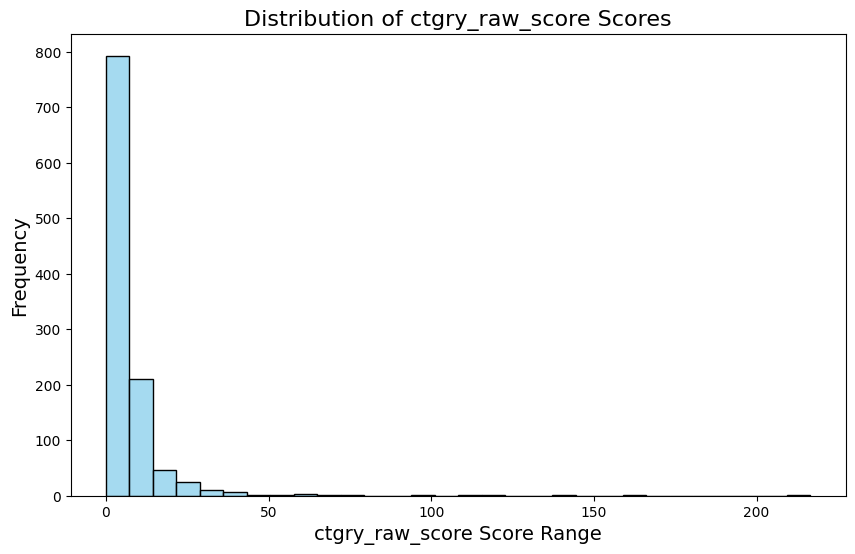

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# 設定圖表大小
plt.figure(figsize=(10, 6))

# 使用 seaborn 繪製直方圖
sns.histplot(df_final["ctgry_raw_score"], bins=30, kde=False, color="skyblue", edgecolor="black")

# 添加標題和標籤
plt.title("Distribution of ctgry_raw_score Scores", fontsize=16)
plt.xlabel("ctgry_raw_score Score Range", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# 顯示圖表
plt.show()